In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/ashrae-energy-prediction/test.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/sample_submission.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from time import time
import datetime
import gc
pd.set_option('display.max_columns',100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

In [3]:
metadata_dtype = {'site_id':"uint8",'building_id':'uint16','square_feet':'uint32','year_built':'float32','floor_count':'float32'}
metadata = pd.read_csv("../input/ashrae-energy-prediction/building_metadata.csv",dtype=metadata_dtype)
metadata.info(memory_usage='deep') 
#memory_usage, deep 일 경우 위 오브젝트 dtype을 조사하여 데이터를 자세하게 조사하고 리턴된 값에 포함

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null uint8
building_id    1449 non-null uint16
primary_use    1449 non-null object
square_feet    1449 non-null uint32
year_built     675 non-null float32
floor_count    355 non-null float32
dtypes: float32(2), object(1), uint16(1), uint32(1), uint8(1)
memory usage: 120.1 KB


In [4]:
weather_dtype = {"site_id":"uint8",'air_temperature':"float32",'cloud_coverage':"float32",'dew_temperature':"float32",'precip_depth_1_hr':"float32",
                 'sea_level_pressure':"float32",'wind_direction':"float32",'wind_speed':"float32"}

weather_train = pd.read_csv("../input/ashrae-energy-prediction/weather_train.csv",parse_dates=['timestamp'],dtype=weather_dtype)
weather_test = pd.read_csv("../input/ashrae-energy-prediction/weather_test.csv",parse_dates=['timestamp'],dtype=weather_dtype)
print (weather_train.info(memory_usage='deep'))
print ("-------------------------------------")
print (weather_test.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null uint8
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float32
cloud_coverage        70600 non-null float32
dew_temperature       139660 non-null float32
precip_depth_1_hr     89484 non-null float32
sea_level_pressure    129155 non-null float32
wind_direction        133505 non-null float32
wind_speed            139469 non-null float32
dtypes: datetime64[ns](1), float32(7), uint8(1)
memory usage: 4.9 MB
None
-------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 9 columns):
site_id               277243 non-null uint8
timestamp             277243 non-null datetime64[ns]
air_temperature       277139 non-null float32
cloud_coverage        136795 non-null float32
dew_temperature       276916 non-null float32
precip_depth_1_h

In [5]:
train = pd.read_csv("../input/ashrae-energy-prediction/train.csv",parse_dates=['timestamp'])
#parse_dates 는 날짜시간으로 시작된 컬럼을 datatime으로 parsing
test_cols_to_read = ['building_id','meter','timestamp']
test = pd.read_csv("../input/ashrae-energy-prediction/test.csv",parse_dates=['timestamp'],usecols=test_cols_to_read)
#pars_cols는 한번 사용 후 더이상 사용x, 대신 usecols사용

In [6]:
test_cols_to_read

['building_id', 'meter', 'timestamp']

In [7]:
#weather_train/test 데이터셋 feature 별 결측치 확인
missing_weather = pd.DataFrame(weather_train.isna().sum()/len(weather_train),columns=["Weather_Train_Missing_Pct"])
missing_weather["Weather_Test_Missing_Pct"] = weather_test.isna().sum()/len(weather_test)
missing_weather

,Weather_Train_Missing_Pct,Weather_Test_Missing_Pct
site_id,0.00000,0.00000
timestamp,0.00000,0.00000
air_temperature,0.00039,0.00038
cloud_coverage,0.49490,0.50659
dew_temperature,0.00081,0.00118
precip_depth_1_hr,0.35979,0.34478
sea_level_pressure,0.07597,0.07670
wind_direction,0.04484,0.04462
wind_speed,0.00217,0.00166


In [8]:
print(metadata.count()) #실제 데이터 수치
print()
print(metadata.isna().sum()) #데이터 결측치
print()
print(metadata.isna().sum()/len(metadata)*100) #데이터 결측치 퍼센트로 나옴
print()
print(metadata.isna().mean()) #mean() 함수로 써도 나타낼 수 있다.

site_id        1449
building_id    1449
primary_use    1449
square_feet    1449
year_built      675
floor_count     355
dtype: int64

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

site_id        0.00000
building_id    0.00000
primary_use    0.00000
square_feet    0.00000
year_built    53.41615
floor_count   75.50035
dtype: float64

site_id       0.00000
building_id   0.00000
primary_use   0.00000
square_feet   0.00000
year_built    0.53416
floor_count   0.75500
dtype: float64


In [9]:
missing_train_test = pd.DataFrame(train.isna().sum()/len(train),columns=["Missiong_Pct_Train"])
missing_train_test["Missing_Pct_Test"] = test.isna().sum()/len(test)
missing_train_test

,Missiong_Pct_Train,Missing_Pct_Test
building_id,0.00000,0.00000
meter,0.00000,0.00000
timestamp,0.00000,0.00000
meter_reading,0.00000,nan


In [10]:
print("train.head()")
print(train.head())
print()
print("train.describe()")
print(train.describe(include='all')) #include all을하면 list의 dtypes 또는 none 다 출력
print()


train.head()
   building_id  meter  timestamp  meter_reading
0            0      0 2016-01-01        0.00000
1            1      0 2016-01-01        0.00000
2            2      0 2016-01-01        0.00000
3            3      0 2016-01-01        0.00000
4            4      0 2016-01-01        0.00000

train.describe()
          building_id          meter            timestamp  meter_reading
count  20216100.00000 20216100.00000             20216100 20216100.00000
unique            nan            nan                 8784            nan
top               nan            nan  2016-12-27 22:00:00            nan
freq              nan            nan                 2370            nan
first             nan            nan  2016-01-01 00:00:00            nan
last              nan            nan  2016-12-31 23:00:00            nan
mean        799.27800        0.66244                  NaN     2117.12108
std         426.91331        0.93099                  NaN   153235.62499
min           0.00000   

In [11]:
#train['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)
#test['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)

Text(0, 0.5, 'count')

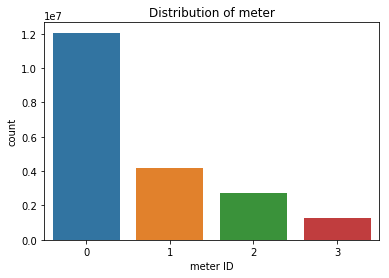

In [12]:
sns.countplot(train['meter'])
plt.title("Distribution of meter")
plt.xlabel("meter ID")
plt.ylabel("count")

In [13]:
train['building_id'].nunique() #유니크한 값의 총 개수를 표현

1449

In [14]:
train[train['building_id'] == 1094]['meter'].unique()

array([0, 1, 2])

In [15]:
train.groupby('meter')['meter_reading'].describe()#agg(['min','max','mean','median','count','std'])
#groupby 함수를 사용할경우 'meter'컬럼의 train의 모든열에 대해 통계량이 계산됨
#agg 를 사용할 경우 일반적인 통계함수를 적용, describe()는 전체 통계량
#std는 표준편차임, 평균에서 관측치가 얼마나 떨어져있나 표시

,count,mean,std,min,25%,50%,75%,max
meter,,,,,,,,
0,12060910.00000,170.82564,380.83431,0.00000,19.50000,62.83190,170.07500,79769.00000
1,4182440.00000,633.36392,7988.21315,0.00000,11.32880,120.48700,464.31400,880374.00000
2,2708713.00000,13882.18769,418313.50364,0.00000,45.75000,257.81200,1035.32000,21904700.00000
3,1264037.00000,385.86678,2508.17250,0.00000,0.00000,39.62370,241.28500,160187.00000


In [16]:
for df in [train, test]:
    df['Month'] = df['timestamp'].dt.month.astype("uint8")
    df['DayOfMonth'] = df['timestamp'].dt.day.astype("uint8")
    df['DayOfWeek'] = df['timestamp'].dt.dayofweek.astype("uint8")
    df['Hour'] = df['timestamp'].dt.hour.astype("uint8")

In [17]:
#train.groupby(['meter','Month','DayOfMonth','DayOfWeek','Hour'])['meter_reading'].agg(['max','mean','median','count','std'])
train.groupby(['meter','Month'])['meter_reading'].agg(['max','mean','median','count','std'])


max        mean    median    count          std
meter Month                                                           
0     1        29431.00000   149.31277  54.25000  1031063    344.26515
      2        25275.00000   154.98008  55.95000   915638    358.88373
      3        44336.50000   149.32664  51.50000   958324    354.88585
      4         6468.86000   148.43819  53.05000  1001113    341.90864
      5         9402.00000   157.95413  55.98250  1033147    362.05878
      6         8876.00000   183.95909  67.93000  1001261    393.94854
      7        19511.00000   189.00237  69.90000  1027852    411.86414
      8        10295.00000   194.16162  74.75000  1024095    401.98539
      9         7894.90000   193.29574  74.58330  1007441    390.09741
      10       79769.00000   173.33757  64.19000  1037744    362.41383
      11       17502.10000   178.84217  68.68800  1002201    407.95454
      12       17999.00000   174.73732  65.58600  1021031    420.84802
1     1        28271.00000   151.19074  21.31210   337659    420.35204
      2        21601.60000   207.66978  47.31440   290218    465.15804
      3        47512.70000   366.86927  88.06190   321893    792.66675
      4        20793.50000   388.60706  96.29140   354758    838.58156
      5       172611.00000   519.05757 154.00300   367763   1115.18966
      6        29639.60000   772.16215 267.98400   356074   1540.70513
      7        85756.40000   892.34872 307.04050   367522   1890.97331
      8        70906.60000   943.69570 338.95400   352706   1943.70787
      9       880374.00000  1760.82720 263.79200   352182  23094.60069
      10      716997.00000   878.40563 121.08200   364181  13726.36908
      11      348495.00000   319.10465  71.14590   350925   1997.16986
      12      198488.00000   281.20449  29.36570   366559   3182.99426
2     1      8243400.00000  7254.35934 698.24200   233100 145766.84027
      2     20392200.00000  8164.74952 532.70000   189600 195681.45338
      3     21724400.00000 39060.41435 332.93600   189590 720316.35048
      4     20413500.00000 39994.50657 317.91250   226686 757326.24303
      5     20032400.00000 36696.15087 180.59450   236032 696257.91296
      6     21904700.00000 28641.53313 109.80000   228299 681610.73047
      7       126750.00000  1056.98752  95.29125   236116   5802.60923
      8       131625.00000  1095.29821 107.43400   237016   5971.78630
      9       105000.00000  1002.11266 132.80350   230820   4182.91241
      10       74250.00000  1232.80198 207.40000   237698   4337.87333
      11    21847900.00000  4713.50651 378.20000   231688 229492.09643
      12      108000.00000  2440.21880 686.38000   232068   6269.00211
3     1       108799.00000   648.93777 146.53600   107028   2434.01681
      2        77125.10000   559.86847 115.97600    99444   2281.44478
      3       116081.00000   465.09597  70.33700   105596   2874.69464
      4        78669.00000   323.65879  46.89140   103779   1318.41143
      5        49371.90000   208.82651  23.34745   106502    732.97307
      6        72090.10000   159.80636   8.79210   103618   1028.67173
      7        87546.50000   261.02911   5.86140   107597   2540.12891
      8        89634.80000   327.35925   5.86140   107368   3410.67490
      9        86517.20000   254.68444   8.62615   104008   2431.00716
      10       80954.40000   273.95581  14.65360   107726   2029.32294
      11      112513.00000   513.34196  64.47560   104210   3292.19951
      12      160187.00000   638.18642  99.64410   107161   3634.61374

In [18]:
train.groupby(['meter','DayOfWeek'])['meter_reading'].agg(['max','mean','median','count','std'])

max        mean    median    count          std
meter DayOfWeek                                                           
0     0            79769.00000   175.68622  65.27000  1711905    399.70550
      1            19511.00000   179.13467  67.65825  1714778    399.70528
      2            44336.50000   179.19996  67.60000  1715699    403.14295
      3            17999.00000   178.70991  67.48000  1715180    398.82351
      4            25275.00000   174.84209  65.04000  1745679    392.60441
      5            31921.00000   155.52113  55.29170  1746705    333.59705
      6            31921.00000   152.85989  53.80000  1710964    329.08661
1     0           793065.00000   649.26167 125.83300   595214   8312.48435
      1           751685.00000   671.75261 132.28000   594969   8489.06425
      2           849418.00000   652.51087 130.40500   594893   7700.23580
      3           828374.00000   645.29194 133.44850   595478   7529.12669
      4           880374.00000   633.13098 123.95000   606214   7951.40021
      5           842194.00000   591.99865 101.81300   603938   7959.58046
      6           740963.00000   589.97852 100.54700   591734   7935.34541
2     0         21904700.00000 12719.08286 265.35000   384571 391956.39484
      1         21382500.00000 14937.29020 258.78900   384322 449612.32951
      2         21847900.00000 16550.23496 259.25000   385848 481477.28790
      3         21508500.00000 14908.27619 257.11500   385606 436376.73327
      4         21889900.00000 14114.88910 265.35000   392299 428203.81538
      5         21724400.00000 12137.56480 250.00000   392026 364885.79593
      6         20629700.00000 11823.34422 246.69300   384041 361567.40932
3     0           116191.00000   397.97435  41.60000   179537   2631.27992
      1           109348.00000   384.96214  41.02990   179520   2482.40760
      2           108594.00000   378.15366  40.11115   179648   2393.34183
      3           116081.00000   386.00091  38.09920   179680   2521.30555
      4           160187.00000   390.34722  39.20425   183026   2450.82999
      5           106629.00000   384.11848  38.09920   183048   2502.73884
      6           108894.00000   379.46387  38.09920   179578   2569.31837

In [19]:
train.head(20)

,building_id,meter,timestamp,meter_reading,Month,DayOfMonth,DayOfWeek,Hour
0,0,0,2016-01-01,0.00000,1,1,4,0
1,1,0,2016-01-01,0.00000,1,1,4,0
2,2,0,2016-01-01,0.00000,1,1,4,0
3,3,0,2016-01-01,0.00000,1,1,4,0
4,4,0,2016-01-01,0.00000,1,1,4,0
5,5,0,2016-01-01,0.00000,1,1,4,0
6,6,0,2016-01-01,0.00000,1,1,4,0
7,7,0,2016-01-01,0.00000,1,1,4,0
8,8,0,2016-01-01,0.00000,1,1,4,0
9,9,0,2016-01-01,0.00000,1,1,4,0


In [20]:
train['meter_reading'].describe()

count   20216100.00000
mean        2117.12108
std       153235.62499
min            0.00000
25%           18.30000
50%           78.77500
75%          267.98400
max     21904700.00000
Name: meter_reading, dtype: float64

Text(0.5, 1.0, 'Distribution of Log of Meter Reading Variable')

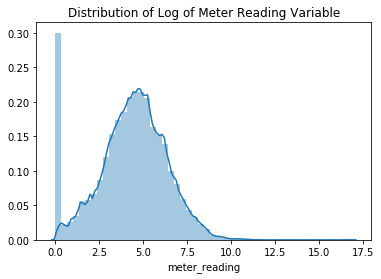

In [21]:
sns.distplot(np.log1p(train['meter_reading']),kde=True)
#kde는 커널밀도곡선으로 같이 표시하려면 True
#np.log1p(z) = log(1+z) 
plt.title("Distribution of Log of Meter Reading Variable")
# Lot of 0 values as can be seen from the distribution

Text(0.5, 1.0, 'Distribution of Log of Meter Reading Variable')

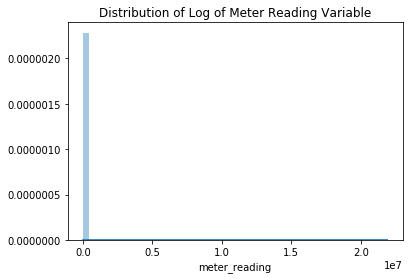

In [22]:
sns.distplot(train['meter_reading'],kde=True)
#kde는 커널밀도곡선으로 같이 표시하려면 True
#np.log1p(z) = log(1+z) 
plt.title("Distribution of Log of Meter Reading Variable")
# Lot of 0 values as can be seen from the distribution

Text(0.5, 1.0, 'Boxplot of Meter Reading Variable for the Meter Type: 0(Electricity)')

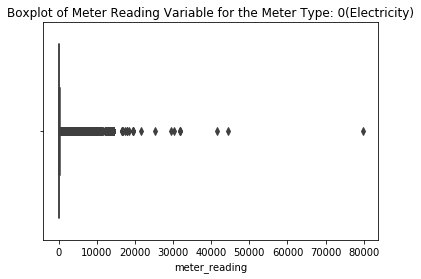

In [23]:
sns.boxplot(train[train['meter'] == 0]['meter_reading'])
# 0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"
plt.title("Boxplot of Meter Reading Variable for the Meter Type: 0(Electricity)")

Text(0.5, 1.0, 'Boxplot of Meter Reading Variable for the Meter Type: 1(ChilledWater)')

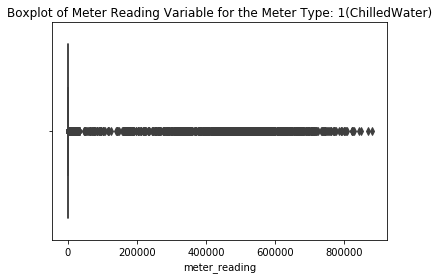

In [24]:
sns.boxplot(train[train['meter'] == 1]['meter_reading'])
# 0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"
plt.title("Boxplot of Meter Reading Variable for the Meter Type: 1(ChilledWater)")

Text(0.5, 1.0, 'Boxplot of Meter Reading Variable for the Meter Type: 2(Steam)')

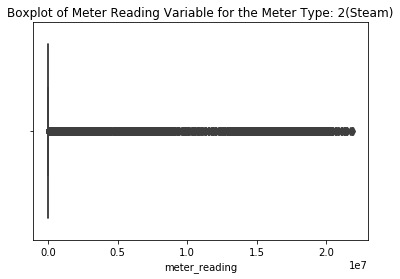

In [25]:
sns.boxplot(train[train['meter'] == 2]['meter_reading'])
# 0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"
plt.title("Boxplot of Meter Reading Variable for the Meter Type: 2(Steam)")

Text(0.5, 1.0, 'Boxplot of Meter Reading Variable for the Meter Type: 3(HotWater)')

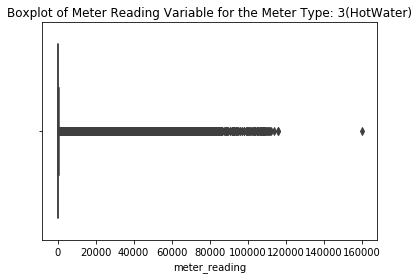

In [26]:
sns.boxplot(train[train['meter'] == 3]['meter_reading'])
# 0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"
plt.title("Boxplot of Meter Reading Variable for the Meter Type: 3(HotWater)")

In [27]:
#값 스케일링 변경
train['meter_reading'] = np.log1p(train['meter_reading'])

Text(0.5, 1.0, 'Distribution of Meter Reading Variable for the Meter Type: 0(Electricity)')

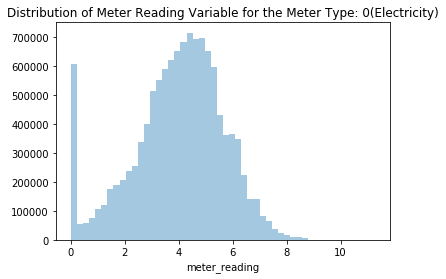

In [28]:
sns.distplot(train[train['meter'] == 0]['meter_reading'],kde=False)
# 0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"
plt.title("Distribution of Meter Reading Variable for the Meter Type: 0(Electricity)")

Text(0.5, 1.0, 'Distribution of Meter Reading Variable for the Meter Type: 1:ChilledWater')

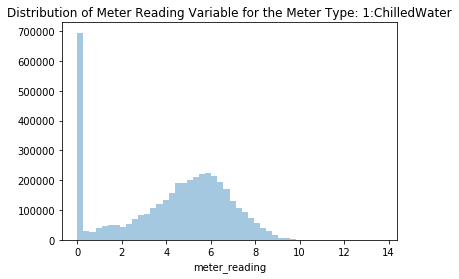

In [29]:
sns.distplot(train[train['meter'] == 1]['meter_reading'],kde=False)
# 0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"
plt.title("Distribution of Meter Reading Variable for the Meter Type: 1:ChilledWater")

Text(0.5, 1.0, 'Distribution of Meter Reading Variable for the Meter Type: 2:Steam')

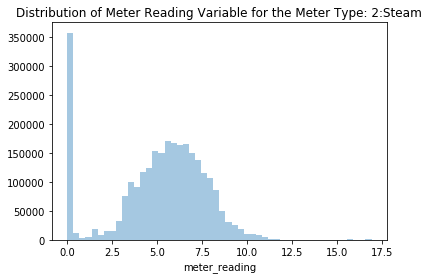

In [30]:
sns.distplot(train[train['meter'] == 2]['meter_reading'],kde=False)
# 0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"
plt.title("Distribution of Meter Reading Variable for the Meter Type: 2:Steam")

Text(0.5, 1.0, 'Distribution of Meter Reading Variable for the Meter Type: 3:HotWater')

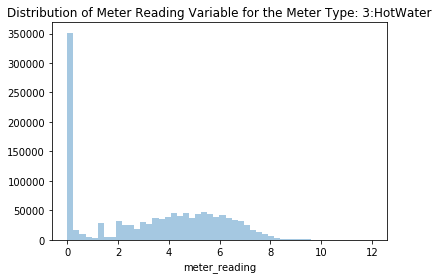

In [31]:
sns.distplot(train[train['meter'] == 3]['meter_reading'],kde=False)
# 0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"
plt.title("Distribution of Meter Reading Variable for the Meter Type: 3:HotWater")

In [32]:
train.head()

,building_id,meter,timestamp,meter_reading,Month,DayOfMonth,DayOfWeek,Hour
0,0,0,2016-01-01,0.00000,1,1,4,0
1,1,0,2016-01-01,0.00000,1,1,4,0
2,2,0,2016-01-01,0.00000,1,1,4,0
3,3,0,2016-01-01,0.00000,1,1,4,0
4,4,0,2016-01-01,0.00000,1,1,4,0


In [33]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null uint8
building_id    1449 non-null uint16
primary_use    1449 non-null object
square_feet    1449 non-null uint32
year_built     675 non-null float32
floor_count    355 non-null float32
dtypes: float32(2), object(1), uint16(1), uint32(1), uint8(1)
memory usage: 32.7+ KB


In [34]:
metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.00000,nan
1,0,1,Education,2720,2004.00000,nan
2,0,2,Education,5376,1991.00000,nan
3,0,3,Education,23685,2002.00000,nan
4,0,4,Education,116607,1975.00000,nan


In [35]:
cols = ['site_id','primary_use','year_built','floor_count','building_id']
for col in metadata:
    print ("Number of Unique Values in the {} column are:".format(col),metadata[col].nunique())

Number of Unique Values in the site_id column are: 16
Number of Unique Values in the building_id column are: 1449
Number of Unique Values in the primary_use column are: 16
Number of Unique Values in the square_feet column are: 1397
Number of Unique Values in the year_built column are: 116
Number of Unique Values in the floor_count column are: 18


In [36]:
cols = ['site_id','primary_use','year_built','floor_count']
for col in cols:
    print ("Unique Values in the {} column are:".format(col),metadata[col].unique())
    print ("\n")

Unique Values in the site_id column are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


Unique Values in the primary_use column are: ['Education' 'Lodging/residential' 'Office'
 'Entertainment/public assembly' 'Other' 'Retail' 'Parking'
 'Public services' 'Warehouse/storage' 'Food sales and service'
 'Religious worship' 'Healthcare' 'Utility' 'Technology/science'
 'Manufacturing/industrial' 'Services']


Unique Values in the year_built column are: [2008. 2004. 1991. 2002. 1975. 2000. 1981. 1989. 2003. 2010. 1968. 1999.
 2013. 1974. 1996. 1980. 1977. 1990. 1985. 2001. 1969. 2005. 2016. 2006.
 2014. 1970. 1971. 2011. 1997. 2007. 1998. 2009. 1979. 1986. 1982. 1983.
   nan 1913. 1953. 1909. 1958. 1960. 1976. 1906. 1900. 1995. 1956. 1930.
 1967. 1919. 1955. 1965. 1907. 2012. 1992. 1948. 1950. 1941. 1957. 1964.
 1940. 1951. 1966. 1934. 1959. 1993. 1939. 1918. 1963. 1987. 1914. 1973.
 1988. 1935. 1942. 2015. 1931. 1928. 1929. 1908. 1927. 1923. 1962. 1944.
 1910. 1949. 2017. 1922. 1911. 1

Text(0, 0.5, 'Count')

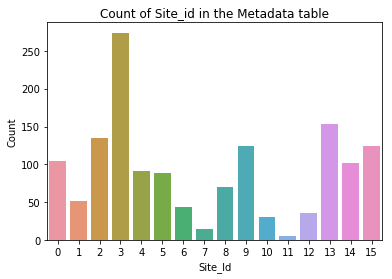

In [37]:
sns.countplot(metadata['site_id'])
plt.title("Count of Site_id in the Metadata table")
plt.xlabel("Site_Id")
plt.ylabel("Count")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

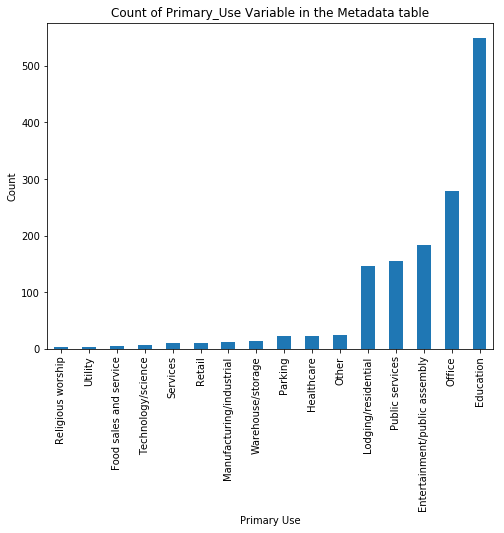

In [38]:
plt.figure(figsize=(8,6))
metadata['primary_use'].value_counts().sort_values().plot(kind='bar')
plt.title("Count of Primary_Use Variable in the Metadata table")
plt.xlabel("Primary Use")
plt.ylabel("Count")
plt.xticks(rotation=90) #x축 인덱스 각도

In [39]:
metadata['square_feet'].describe()

count     1449.00000
mean     92111.77640
std     110769.95100
min        283.00000
25%      23012.00000
50%      57673.00000
75%     115676.00000
max     875000.00000
Name: square_feet, dtype: float64

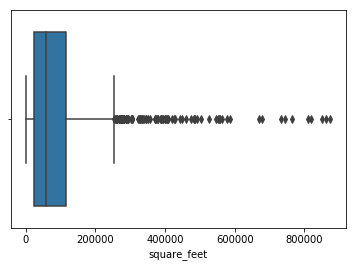

In [40]:
sns.boxplot(metadata['square_feet'])

In [41]:
metadata['square_feet'] = np.log1p(metadata['square_feet'])

Text(0, 0.5, 'Frequency')

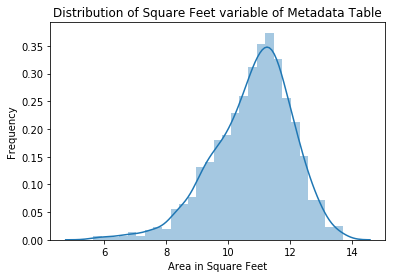

In [42]:
sns.distplot(metadata['square_feet'])
plt.title("Distribution of Square Feet variable of Metadata Table")
plt.xlabel("Area in Square Feet")
plt.ylabel("Frequency")
# Looks like a normal distribution distribution

Text(0.5, 1.0, 'Box Plot of Square Feet Variable')

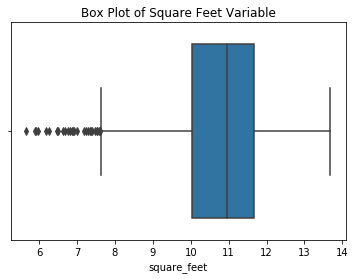

In [43]:
sns.boxplot(metadata['square_feet'])
plt.title("Box Plot of Square Feet Variable")
# There are a few outliers visible

In [44]:
metadata.groupby('primary_use')['square_feet'].agg(['mean','median','count','std']).sort_values(by='count')
# Parking has the highest average are although the count is less.
# Education has the highest count as can be seen in the countplot above.

,mean,median,count,std
primary_use,,,,
Religious worship,8.87157,9.21044,3,1.33837
Utility,9.89873,10.02942,4,1.19878
Food sales and service,10.48744,10.41079,5,0.39751
Technology/science,10.74879,10.94313,6,0.86814
Services,11.60188,11.71587,10,1.32401
Retail,9.80526,10.36303,11,1.70635
Manufacturing/industrial,10.08105,9.97431,12,1.17919
Warehouse/storage,10.18141,9.85535,13,1.07104
Parking,11.86441,12.74982,22,1.87272


In [45]:
metadata.groupby('site_id')['square_feet'].agg(['mean','median','count','std']).sort_values(by='count')
# Parking has the highest average are although the count is less.
# Education has the highest count as can be seen in the countplot above.

,mean,median,count,std
site_id,,,,
11,11.51391,11.44258,5,0.32927
7,12.41399,12.57979,15,0.81741
10,10.78688,10.98922,30,1.01415
12,10.84723,10.95023,36,1.04600
6,11.17106,11.11811,44,0.70547
1,10.86630,10.96256,51,0.73075
8,8.97528,8.92962,70,1.50313
5,10.28552,10.25288,89,1.00832
4,10.87515,11.12942,91,1.30237


Text(0.5, 1.0, 'Distribution of Year Built Variable')

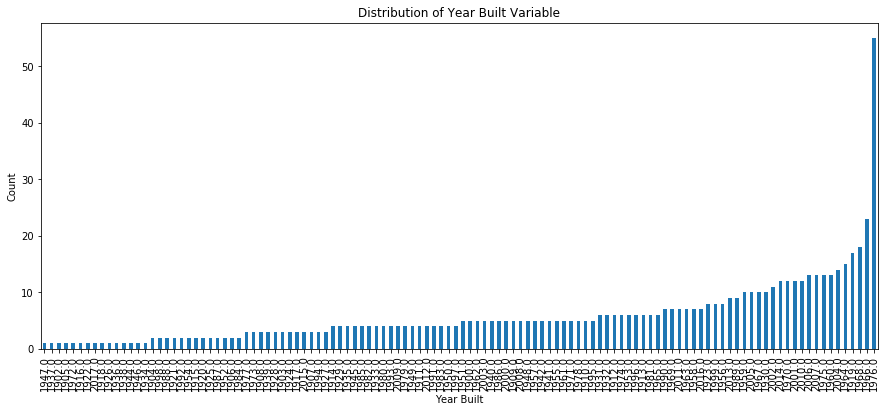

In [46]:
metadata['year_built'].value_counts().sort_values().plot(kind='bar',figsize=(15,6))
#metadata['year_built'].value_counts().plot(kind='bar',figsize=(15,6))
plt.xlabel("Year Built")
plt.ylabel("Count")
plt.title("Distribution of Year Built Variable")

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]),
 <a list of 116 Text xticklabel objects>)

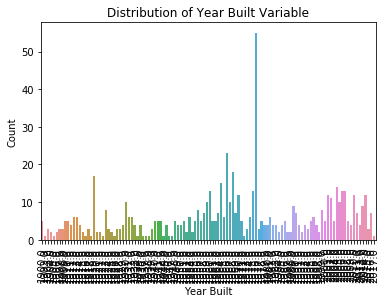

In [47]:
sns.countplot(metadata['year_built'])
plt.xlabel("Year Built")
plt.ylabel("Count")
plt.title("Distribution of Year Built Variable")
plt.xticks(rotation=90)

Text(0, 0.5, 'Count of Buildings')

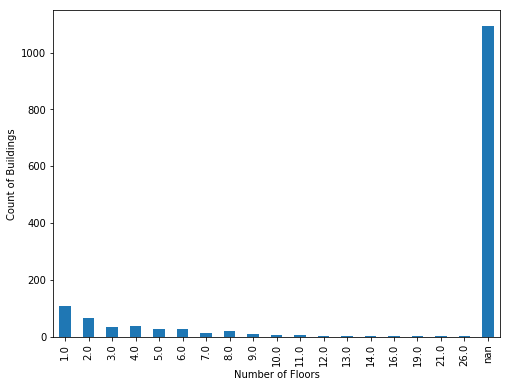

In [48]:
metadata['floor_count'].value_counts(dropna=False).sort_index().plot(kind='bar',figsize=(8,6))
plt.xlabel("Number of Floors")
plt.ylabel("Count of Buildings")
# Lot of missing values here as well
# Maximum number of floors is 26

In [49]:
metadata.groupby('floor_count')['square_feet'].agg(['count','mean','median']).sort_values(by='count')

,count,mean,median
floor_count,,,
26.00000,1,13.17578,13.17578
19.00000,1,12.57979,12.57979
16.00000,1,11.04921,11.04921
14.00000,1,12.50771,12.50771
21.00000,1,12.92154,12.92154
13.00000,2,12.69689,12.69689
12.00000,2,12.34807,12.34807
10.00000,4,11.60682,11.57517
11.00000,5,12.14045,12.11694


In [50]:
metadata.groupby('primary_use')['square_feet'].agg(['count','mean','median']).sort_values(by='count')

,count,mean,median
primary_use,,,
Religious worship,3,8.87157,9.21044
Utility,4,9.89873,10.02942
Food sales and service,5,10.48744,10.41079
Technology/science,6,10.74879,10.94313
Services,10,11.60188,11.71587
Retail,11,9.80526,10.36303
Manufacturing/industrial,12,10.08105,9.97431
Warehouse/storage,13,10.18141,9.85535
Parking,22,11.86441,12.74982


In [51]:
metadata.groupby('primary_use')['floor_count'].agg(['count','mean','median']).sort_values(by='count')

,count,mean,median
primary_use,,,
Food sales and service,0,nan,nan
Religious worship,0,nan,nan
Services,0,nan,nan
Healthcare,1,1.00000,1.00000
Utility,1,2.00000,2.00000
Retail,2,1.50000,1.50000
Warehouse/storage,2,1.00000,1.00000
Manufacturing/industrial,3,1.66667,2.00000
Parking,3,2.66667,2.00000


In [52]:
metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,8.91368,2008.00000,nan
1,0,1,Education,7.90875,2004.00000,nan
2,0,2,Education,8.58989,1991.00000,nan
3,0,3,Education,10.07264,2002.00000,nan
4,0,4,Education,11.66657,1975.00000,nan


In [53]:
#fillna 함수는 NaN 값을 다른것으로 대체
metadata['year_built'].fillna(-999, inplace=True)
#NaN 값을 -999로 변경 및 실제 데이터프레임에 저장(inplace=true)
metadata['year_built'] = metadata['year_built'].astype('int16')
metadata['floor_count'].fillna(-999, inplace=True)
metadata['floor_count'] = metadata['floor_count'].astype('float32')

In [54]:
metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,8.91368,2008,-999.00000
1,0,1,Education,7.90875,2004,-999.00000
2,0,2,Education,8.58989,1991,-999.00000
3,0,3,Education,10.07264,2002,-999.00000
4,0,4,Education,11.66657,1975,-999.00000


**Weather Data(Train)**

In [55]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.00000,6.00000,20.00000,nan,1019.70001,0.00000,0.00000
1,0,2016-01-01 01:00:00,24.40000,nan,21.10000,-1.00000,1020.20001,70.00000,1.50000
2,0,2016-01-01 02:00:00,22.80000,2.00000,21.10000,0.00000,1020.20001,0.00000,0.00000
3,0,2016-01-01 03:00:00,21.10000,2.00000,20.60000,0.00000,1020.09998,0.00000,0.00000
4,0,2016-01-01 04:00:00,20.00000,2.00000,20.00000,-1.00000,1020.00000,250.00000,2.60000


In [56]:
weather_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null uint8
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float32
cloud_coverage        70600 non-null float32
dew_temperature       139660 non-null float32
precip_depth_1_hr     89484 non-null float32
sea_level_pressure    129155 non-null float32
wind_direction        133505 non-null float32
wind_speed            139469 non-null float32
dtypes: datetime64[ns](1), float32(7), uint8(1)
memory usage: 4.9 MB


In [57]:
#결측치 있는 column 에 대해 조회
cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
for col in cols:
    print (" Minimum Value of {} column is {}".format(col,weather_train[col].min()))
    print (" Maximum Value of {} column is {}".format(col,weather_train[col].max()))
    print ("----------------------------------------------------------------------")

 Minimum Value of air_temperature column is -28.899999618530273
 Maximum Value of air_temperature column is 47.20000076293945
----------------------------------------------------------------------
 Minimum Value of cloud_coverage column is 0.0
 Maximum Value of cloud_coverage column is 9.0
----------------------------------------------------------------------
 Minimum Value of dew_temperature column is -35.0
 Maximum Value of dew_temperature column is 26.100000381469727
----------------------------------------------------------------------
 Minimum Value of precip_depth_1_hr column is -1.0
 Maximum Value of precip_depth_1_hr column is 343.0
----------------------------------------------------------------------
 Minimum Value of sea_level_pressure column is 968.2000122070312
 Maximum Value of sea_level_pressure column is 1045.5
----------------------------------------------------------------------
 Minimum Value of wind_direction column is 0.0
 Maximum Value of wind_direction column is 

In [58]:
weather_train.isna().mean()

site_id              0.00000
timestamp            0.00000
air_temperature      0.00039
cloud_coverage       0.49490
dew_temperature      0.00081
precip_depth_1_hr    0.35979
sea_level_pressure   0.07597
wind_direction       0.04484
wind_speed           0.00217
dtype: float64

In [59]:
weather_train[['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_speed']].describe()

,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed
count,139718.00000,70600.00000,139660.00000,89484.00000,129155.00000,139469.00000
mean,14.41809,2.14931,7.35006,0.98305,1016.15857,3.55785
std,10.62666,2.59949,9.79095,8.46529,7.62963,2.33596
min,-28.90000,0.00000,-35.00000,-1.00000,968.20001,0.00000
25%,7.20000,0.00000,0.60000,0.00000,1011.79999,2.10000
50%,15.00000,2.00000,8.30000,0.00000,1016.40002,3.10000
75%,22.20000,4.00000,14.40000,0.00000,1020.79999,5.00000
max,47.20000,9.00000,26.10000,343.00000,1045.50000,19.00000


1. Missing values in air_temperature, cloud_coverage, dew_temperature, precip_depth_1_hr, sea_level_pressure, wind_speed variables
2. There are negative values in air_temperature, dew_temperature and precip_depth_1_hr variables.
3. Looks like there are outliers in precip_depth_1_hr variable (can be guessed from Max value).
4. min value of wind_speed as 0 does not make any sense.

In [60]:
weather_train['timestamp'].describe()

count                  139773
unique                   8784
top       2016-11-04 05:00:00
freq                       16
first     2016-01-01 00:00:00
last      2016-12-31 23:00:00
Name: timestamp, dtype: object

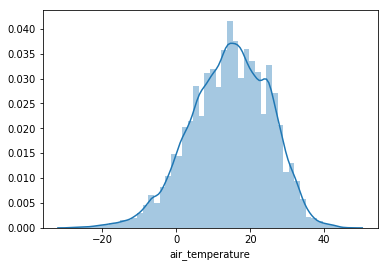

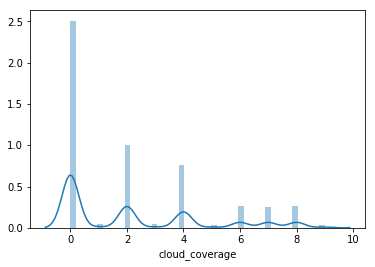

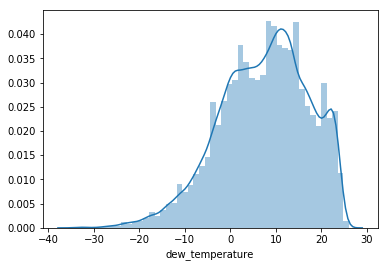

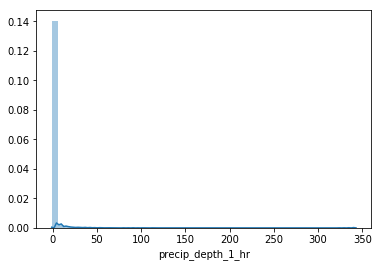

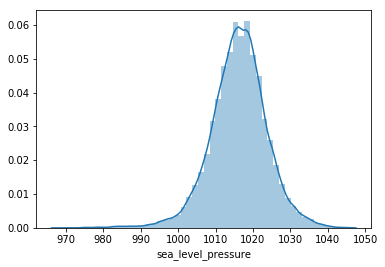

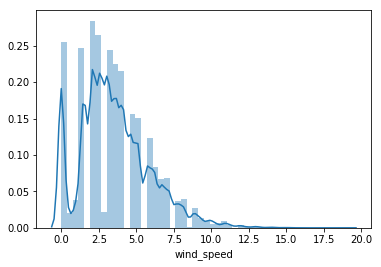

In [61]:
cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_speed']
for ind,col in enumerate(weather_train[cols]):
    plt.figure(ind)
    sns.distplot(weather_train[col].dropna())
    #결측치를 제외하고 각각 값 출력

1. Distribution of sea_level_pressure looks like a normal distribution.
2. Lot of 0 values in precip_depth_1_hr variable.
3. Wind_Speed distribution looks like positively skewed.
4. Dew Temperature looks like a Negatively skewed distribution.
5. Cloud_Coverage takes distinct values unlike these other variables.

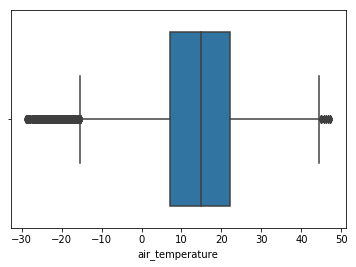

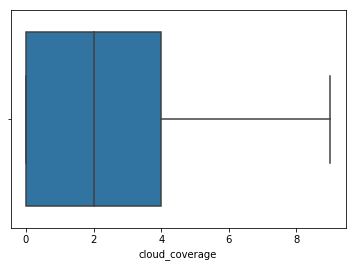

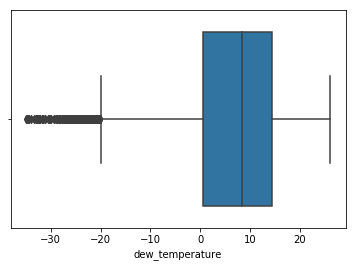

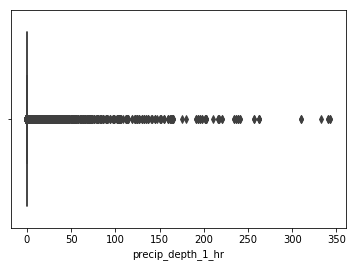

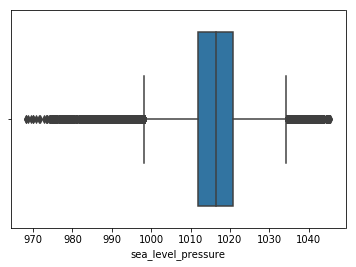

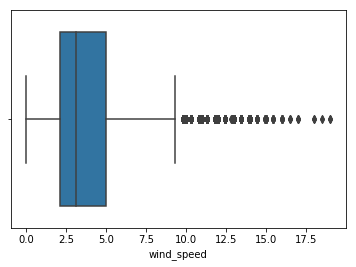

In [62]:
cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_speed']
for ind,col in enumerate(weather_train[cols]):
    plt.figure(ind)
    sns.boxplot(weather_train[col].dropna())

**Weather_Test data**

In [63]:
weather_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 9 columns):
site_id               277243 non-null uint8
timestamp             277243 non-null datetime64[ns]
air_temperature       277139 non-null float32
cloud_coverage        136795 non-null float32
dew_temperature       276916 non-null float32
precip_depth_1_hr     181655 non-null float32
sea_level_pressure    255978 non-null float32
wind_direction        264873 non-null float32
wind_speed            276783 non-null float32
dtypes: datetime64[ns](1), float32(7), uint8(1)
memory usage: 9.8 MB


In [64]:
weather_test['timestamp'].describe()
# The time duration is similar to the test dataset.

count                  277243
unique                  17520
top       2018-12-06 13:00:00
freq                       16
first     2017-01-01 00:00:00
last      2018-12-31 23:00:00
Name: timestamp, dtype: object

**Merging Data**

In [65]:
%%time
train = pd.merge(train,metadata,on='building_id',how='left')
test  = pd.merge(test,metadata,on='building_id',how='left')
print ("Training Data Shape {}".format(train.shape))
print ("Testing Data Shape {}".format(test.shape))
gc.collect()

Training Data Shape (20216100, 13)
Testing Data Shape (41697600, 12)
CPU times: user 12.8 s, sys: 12.6 s, total: 25.4 s
Wall time: 22.9 s


43272

In [66]:
%%time
train = pd.merge(train,weather_train,on=['site_id','timestamp'],how='left')
test  = pd.merge(test,weather_test,on=['site_id','timestamp'],how='left')
print ("Training Data Shape {}".format(train.shape))
print ("Testing Data Shape {}".format(test.shape))
gc.collect()

Training Data Shape (20216100, 20)
Testing Data Shape (41697600, 19)
CPU times: user 13.1 s, sys: 12.9 s, total: 26 s
Wall time: 23.9 s


0

In [67]:
cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
for col in cols:
    train[col].fillna(train[col].mean(),inplace=True)
    test[col].fillna(test[col].mean(),inplace=True)
    
del metadata, weather_train, weather_test

In [68]:
%%time
for df in [train, test]:
    df['air_temperature'] = df['air_temperature'].astype('float16')
    df['cloud_coverage'] = df['cloud_coverage'].astype("float16")
    df['dew_temperature'] = df['dew_temperature'].astype('float16')
    df['precip_depth_1_hr'] = df['precip_depth_1_hr'].astype('float32')
    df['sea_level_pressure'] = df['sea_level_pressure'].astype('float32')
    df['wind_direction'] = df['wind_direction'].astype('float32')
    df['wind_speed'] = df['wind_speed'].astype('float16')
    df['square_feet'] = df['square_feet'].astype("float32")
    df['building_id'] = df['building_id'].astype("int16")

CPU times: user 3.74 s, sys: 5.86 s, total: 9.6 s
Wall time: 5.7 s


In [69]:
train.drop('timestamp',axis=1,inplace=True)
test.drop('timestamp',axis=1,inplace=True)

In [76]:
%%time
number_unique_meter_per_building = train.groupby('building_id')['meter'].nunique()
train['number_unique_meter_per_building'] = train['building_id'].map(number_unique_meter_per_building)


mean_meter_reading_per_building = train.groupby('building_id')['meter_reading'].mean()
train['mean_meter_reading_per_building'] = train['building_id'].map(mean_meter_reading_per_building)
median_meter_reading_per_building = train.groupby('building_id')['meter_reading'].median()
train['median_meter_reading_per_building'] = train['building_id'].map(median_meter_reading_per_building)
std_meter_reading_per_building = train.groupby('building_id')['meter_reading'].std()
train['std_meter_reading_per_building'] = train['building_id'].map(std_meter_reading_per_building)


mean_meter_reading_on_year_built = train.groupby('year_built')['meter_reading'].mean()
train['mean_meter_reading_on_year_built'] = train['year_built'].map(mean_meter_reading_on_year_built)
median_meter_reading_on_year_built = train.groupby('year_built')['meter_reading'].median()
train['median_meter_reading_on_year_built'] = train['year_built'].map(median_meter_reading_on_year_built)
std_meter_reading_on_year_built = train.groupby('year_built')['meter_reading'].std()
train['std_meter_reading_on_year_built'] = train['year_built'].map(std_meter_reading_on_year_built)


mean_meter_reading_per_meter = train.groupby('meter')['meter_reading'].mean()
train['mean_meter_reading_per_meter'] = train['meter'].map(mean_meter_reading_per_meter)
median_meter_reading_per_meter = train.groupby('meter')['meter_reading'].median()
train['median_meter_reading_per_meter'] = train['meter'].map(median_meter_reading_per_meter)
std_meter_reading_per_meter = train.groupby('meter')['meter_reading'].std()
train['std_meter_reading_per_meter'] = train['meter'].map(std_meter_reading_per_meter)


mean_meter_reading_per_primary_usage = train.groupby('primary_use')['meter_reading'].mean()
train['mean_meter_reading_per_primary_usage'] = train['primary_use'].map(mean_meter_reading_per_primary_usage)
median_meter_reading_per_primary_usage = train.groupby('primary_use')['meter_reading'].median()
train['median_meter_reading_per_primary_usage'] = train['primary_use'].map(median_meter_reading_per_primary_usage)
std_meter_reading_per_primary_usage = train.groupby('primary_use')['meter_reading'].std()
train['std_meter_reading_per_primary_usage'] = train['primary_use'].map(std_meter_reading_per_primary_usage)


mean_meter_reading_per_site_id = train.groupby('site_id')['meter_reading'].mean()
train['mean_meter_reading_per_site_id'] = train['site_id'].map(mean_meter_reading_per_site_id)
median_meter_reading_per_site_id = train.groupby('site_id')['meter_reading'].median()
train['median_meter_reading_per_site_id'] = train['site_id'].map(median_meter_reading_per_site_id)
std_meter_reading_per_site_id = train.groupby('site_id')['meter_reading'].std()
train['std_meter_reading_per_site_id'] = train['site_id'].map(std_meter_reading_per_site_id)


test['number_unique_meter_per_building'] = test['building_id'].map(number_unique_meter_per_building)

test['mean_meter_reading_per_building'] = test['building_id'].map(mean_meter_reading_per_building)
test['median_meter_reading_per_building'] = test['building_id'].map(median_meter_reading_per_building)
test['std_meter_reading_per_building'] = test['building_id'].map(std_meter_reading_per_building)

test['mean_meter_reading_on_year_built'] = test['year_built'].map(mean_meter_reading_on_year_built)
test['median_meter_reading_on_year_built'] = test['year_built'].map(median_meter_reading_on_year_built)
test['std_meter_reading_on_year_built'] = test['year_built'].map(std_meter_reading_on_year_built)

test['mean_meter_reading_per_meter'] = test['meter'].map(mean_meter_reading_per_meter)
test['median_meter_reading_per_meter'] = test['meter'].map(median_meter_reading_per_meter)
test['std_meter_reading_per_meter'] = test['meter'].map(std_meter_reading_per_meter)

test['mean_meter_reading_per_primary_usage'] = test['primary_use'].map(mean_meter_reading_per_primary_usage)
test['median_meter_reading_per_primary_usage'] = test['primary_use'].map(median_meter_reading_per_primary_usage)
test['std_meter_reading_per_primary_usage'] = test['primary_use'].map(std_meter_reading_per_primary_usage)

test['mean_meter_reading_per_site_id'] = test['site_id'].map(mean_meter_reading_per_site_id)
test['median_meter_reading_per_site_id'] = test['site_id'].map(median_meter_reading_per_site_id)
test['std_meter_reading_per_site_id'] = test['site_id'].map(std_meter_reading_per_site_id)

CPU times: user 36.7 s, sys: 49.1 s, total: 1min 25s
Wall time: 1min 4s


In [77]:
%%time
for df in [train, test]:
    df['mean_meter_reading_per_building'] = df['mean_meter_reading_per_building'].astype("float16")
    df['median_meter_reading_per_building'] = df['mean_meter_reading_per_building'].astype("float16")
    df['std_meter_reading_per_building'] = df['std_meter_reading_per_building'].astype("float16")
    
    df['mean_meter_reading_on_year_built'] = df['mean_meter_reading_on_year_built'].astype("float16")
    df['median_meter_reading_on_year_built'] = df['median_meter_reading_on_year_built'].astype("float16")
    df['std_meter_reading_on_year_built'] = df['std_meter_reading_on_year_built'].astype("float16")
    
    df['mean_meter_reading_per_meter'] = df['mean_meter_reading_per_meter'].astype("float16")
    df['median_meter_reading_per_meter'] = df['median_meter_reading_per_meter'].astype("float16")
    df['std_meter_reading_per_meter'] = df['std_meter_reading_per_meter'].astype("float16")
    
    df['mean_meter_reading_per_primary_usage'] = df['mean_meter_reading_per_primary_usage'].astype("float16")
    df['median_meter_reading_per_primary_usage'] = df['median_meter_reading_per_primary_usage'].astype("float16")
    df['std_meter_reading_per_primary_usage'] = df['std_meter_reading_per_primary_usage'].astype("float16")
    
    df['mean_meter_reading_per_site_id'] = df['mean_meter_reading_per_site_id'].astype("float16")
    df['median_meter_reading_per_site_id'] = df['median_meter_reading_per_site_id'].astype("float16")
    df['std_meter_reading_per_site_id'] = df['std_meter_reading_per_site_id'].astype("float16")
    
    df['number_unique_meter_per_building'] = df['number_unique_meter_per_building'].astype('uint8')
    df['square_feet'] = df['square_feet'].astype('float16')
gc.collect()

CPU times: user 12.1 s, sys: 18.5 s, total: 30.6 s
Wall time: 18.4 s


159

In [72]:
print (train.shape, test.shape)

(20216100, 35) (41697600, 20)


In [73]:
%%time
le = LabelEncoder()

train['meter']= le.fit_transform(train['meter']).astype("uint8")
test['meter']= le.fit_transform(test['meter']).astype("uint8")
train['primary_use']= le.fit_transform(train['primary_use']).astype("uint8")
test['primary_use']= le.fit_transform(test['primary_use']).astype("uint8")

CPU times: user 24.7 s, sys: 2.29 s, total: 27 s
Wall time: 26.4 s


In [78]:
%%time
# Let's check the correlation between the variables and eliminate the one's that have high correlation
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

CPU times: user 1min 12s, sys: 4.8 s, total: 1min 17s
Wall time: 1min 16s


,building_id,meter,meter_reading,Month,DayOfMonth,DayOfWeek,Hour,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,number_unique_meter_per_building,mean_meter_reading_per_building,median_meter_reading_per_building,std_meter_reading_per_building,mean_meter_reading_on_year_built,median_meter_reading_on_year_built,std_meter_reading_on_year_built,mean_meter_reading_per_meter,median_meter_reading_per_meter,std_meter_reading_per_meter,mean_meter_reading_per_primary_usage,median_meter_reading_per_primary_usage,std_meter_reading_per_primary_usage,mean_meter_reading_per_site_id,median_meter_reading_per_site_id,std_meter_reading_per_site_id
building_id,1.00000,0.22227,0.12640,0.01452,0.00036,0.00005,0.00005,0.98097,0.05824,0.16009,0.44696,0.14160,0.31313,0.15413,0.10970,0.02017,0.01954,0.04793,0.00401,0.40415,0.19460,0.19460,0.15435,0.07899,0.03243,0.05674,0.29377,0.31697,0.27117,0.06089,0.06263,0.05321,0.47828,0.30252,0.17592
meter,0.22227,1.00000,0.06436,0.00529,0.00002,0.00006,0.00011,0.25388,0.08176,0.22215,0.12570,0.17107,0.01115,0.13378,0.08025,0.00207,0.06876,0.02224,0.08080,0.52549,0.16347,0.16347,0.35672,0.10974,0.10568,0.09661,0.31717,0.47035,0.89148,0.11405,0.13085,0.11581,0.31632,0.32174,0.22274
meter_reading,0.12640,0.06436,1.00000,0.04739,0.00722,0.02585,0.03328,0.13990,0.06264,0.44466,0.04602,0.13645,0.00470,0.02431,0.00834,0.00267,0.09599,0.01467,0.03225,0.19950,0.64942,0.64942,0.07845,0.21892,0.19874,0.02445,0.20262,0.19512,0.10084,0.15441,0.14821,0.08100,0.26119,0.24037,0.12325
Month,0.01452,0.00529,0.04739,1.00000,0.01177,0.00253,0.00004,0.01445,0.00226,0.00046,0.01919,0.00909,0.16809,0.00717,0.24111,0.00664,0.06397,0.02595,0.06927,0.00325,0.00309,0.00309,0.00419,0.00199,0.00267,0.00548,0.00933,0.01082,0.00920,0.00020,0.00128,0.00057,0.00473,0.00495,0.00301
DayOfMonth,0.00036,0.00002,0.00722,0.01177,1.00000,0.00338,0.00029,0.00047,0.00018,0.00087,0.00056,0.00128,0.02005,0.00735,0.01883,0.00282,0.01802,0.01778,0.01071,0.00053,0.00036,0.00036,0.00017,0.00017,0.00013,0.00043,0.00016,0.00005,0.00014,0.00053,0.00061,0.00027,0.00093,0.00066,0.00026


In [79]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,building_id,meter,meter_reading,Month,DayOfMonth,DayOfWeek,Hour,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,number_unique_meter_per_building,mean_meter_reading_per_building,median_meter_reading_per_building,std_meter_reading_per_building,mean_meter_reading_on_year_built,median_meter_reading_on_year_built,std_meter_reading_on_year_built,mean_meter_reading_per_meter,median_meter_reading_per_meter,std_meter_reading_per_meter,mean_meter_reading_per_primary_usage,median_meter_reading_per_primary_usage,std_meter_reading_per_primary_usage,mean_meter_reading_per_site_id,median_meter_reading_per_site_id,std_meter_reading_per_site_id
building_id,nan,0.22227,0.12640,0.01452,0.00036,0.00005,0.00005,0.98097,0.05824,0.16009,0.44696,0.14160,0.31313,0.15413,0.10970,0.02017,0.01954,0.04793,0.00401,0.40415,0.19460,0.19460,0.15435,0.07899,0.03243,0.05674,0.29377,0.31697,0.27117,0.06089,0.06263,0.05321,0.47828,0.30252,0.17592
meter,nan,nan,0.06436,0.00529,0.00002,0.00006,0.00011,0.25388,0.08176,0.22215,0.12570,0.17107,0.01115,0.13378,0.08025,0.00207,0.06876,0.02224,0.08080,0.52549,0.16347,0.16347,0.35672,0.10974,0.10568,0.09661,0.31717,0.47035,0.89148,0.11405,0.13085,0.11581,0.31632,0.32174,0.22274
meter_reading,nan,nan,nan,0.04739,0.00722,0.02585,0.03328,0.13990,0.06264,0.44466,0.04602,0.13645,0.00470,0.02431,0.00834,0.00267,0.09599,0.01467,0.03225,0.19950,0.64942,0.64942,0.07845,0.21892,0.19874,0.02445,0.20262,0.19512,0.10084,0.15441,0.14821,0.08100,0.26119,0.24037,0.12325
Month,nan,nan,nan,nan,0.01177,0.00253,0.00004,0.01445,0.00226,0.00046,0.01919,0.00909,0.16809,0.00717,0.24111,0.00664,0.06397,0.02595,0.06927,0.00325,0.00309,0.00309,0.00419,0.00199,0.00267,0.00548,0.00933,0.01082,0.00920,0.00020,0.00128,0.00057,0.00473,0.00495,0.00301
DayOfMonth,nan,nan,nan,nan,nan,0.00338,0.00029,0.00047,0.00018,0.00087,0.00056,0.00128,0.02005,0.00735,0.01883,0.00282,0.01802,0.01778,0.01071,0.00053,0.00036,0.00036,0.00017,0.00017,0.00013,0.00043,0.00016,0.00005,0.00014,0.00053,0.00061,0.00027,0.00093,0.00066,0.00026


In [80]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
print ("Following columns can be dropped {}".format(to_drop))

There are 6 columns to remove.
Following columns can be dropped ['site_id', 'median_meter_reading_per_building', 'median_meter_reading_on_year_built', 'median_meter_reading_per_meter', 'median_meter_reading_per_primary_usage', 'median_meter_reading_per_site_id']


In [81]:
train.drop(to_drop,axis=1,inplace=True)
test.drop(to_drop,axis=1,inplace=True)

In [82]:
train.corr()['meter_reading'].sort_values()

floor_count                            -0.13645
primary_use                            -0.06264
year_built                             -0.04602
wind_speed                             -0.03225
DayOfWeek                              -0.02585
cloud_coverage                         -0.02431
wind_direction                         -0.01467
air_temperature                        -0.00470
precip_depth_1_hr                       0.00267
DayOfMonth                              0.00722
dew_temperature                         0.00834
std_meter_reading_on_year_built         0.02445
Hour                                    0.03328
Month                                   0.04739
meter                                   0.06436
std_meter_reading_per_building          0.07845
std_meter_reading_per_primary_usage     0.08100
sea_level_pressure                      0.09599
std_meter_reading_per_meter             0.10084
std_meter_reading_per_site_id           0.12325
building_id                             

In [83]:
train.drop(['air_temperature','precip_depth_1_hr','DayOfMonth','dew_temperature'],axis=1,inplace=True)
test.drop(['air_temperature','precip_depth_1_hr','DayOfMonth','dew_temperature'],axis=1,inplace=True)

In [84]:
y = train['meter_reading']
train.drop('meter_reading',axis=1,inplace=True)

In [85]:
train.head()

,building_id,meter,Month,DayOfWeek,Hour,primary_use,square_feet,year_built,floor_count,cloud_coverage,sea_level_pressure,wind_direction,wind_speed,number_unique_meter_per_building,mean_meter_reading_per_building,std_meter_reading_per_building,mean_meter_reading_on_year_built,std_meter_reading_on_year_built,mean_meter_reading_per_meter,std_meter_reading_per_meter,mean_meter_reading_per_primary_usage,std_meter_reading_per_primary_usage,mean_meter_reading_per_site_id,std_meter_reading_per_site_id
0,0,0,1,4,0,0,8.91406,2008,-999.00000,6.00000,1019.70001,0.00000,0.00000,1,3.35547,2.65820,3.79688,2.28711,3.97852,1.70508,4.37891,2.22461,3.77734,2.96289
1,1,0,1,4,0,0,7.91016,2004,-999.00000,6.00000,1019.70001,0.00000,0.00000,1,2.99023,2.30273,4.18750,1.61621,3.97852,1.70508,4.37891,2.22461,3.77734,2.96289
2,2,0,1,4,0,0,8.59375,1991,-999.00000,6.00000,1019.70001,0.00000,0.00000,1,1.85156,1.55371,3.94727,2.52539,3.97852,1.70508,4.37891,2.22461,3.77734,2.96289
3,3,0,1,4,0,0,10.07031,2002,-999.00000,6.00000,1019.70001,0.00000,0.00000,1,3.62695,2.88281,3.38672,2.24609,3.97852,1.70508,4.37891,2.22461,3.77734,2.96289
4,4,0,1,4,0,0,11.66406,1975,-999.00000,6.00000,1019.70001,0.00000,0.00000,1,4.54688,3.57617,4.15625,1.85547,3.97852,1.70508,4.37891,2.22461,3.77734,2.96289


In [86]:
categorical_cols = ['building_id','Month','meter','Hour','primary_use','DayOfWeek']

일단 여기까지 20191114 04:56

마크2